In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle

# 1. Dataset
- Binary Classification Cat vs non-cat Images


In [2]:
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
train_y = train_y.reshape(-1)
test_y = test_y.reshape(-1)

print(f'{train_x_orig.shape = }', f'{train_y.shape = }')
print(f'{test_x_orig.shape = }', f'{test_y.shape = }')

train_x_orig.shape = (209, 64, 64, 3) train_y.shape = (209,)
test_x_orig.shape = (50, 64, 64, 3) test_y.shape = (50,)


#### View

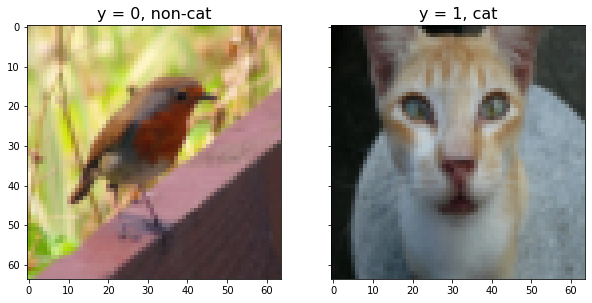

In [3]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=True)

index = 10
label = 'non-cat' if (train_y[index] == 0) else 'cat'
axs[0].imshow(train_x_orig[index])
axs[0].set_title(f'y = {train_y[index]}, {label}', size=16)

index = 11
label = 'non-cat' if (train_y[index] == 0) else 'cat'
axs[1].imshow(train_x_orig[index])
axs[1].set_title(f'y = {train_y[index]}, {label}', size=16)

plt.show()

#### Flatten

In [4]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1)
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1)

#### Normalization

In [5]:
train_x_flatten = train_x_flatten/255.
test_x_flatten = test_x_flatten/255.

In [6]:
print(f'{train_x_flatten.shape = }', f'{train_y.shape = }')
print(f'{test_x_flatten.shape = }', f'{test_y.shape = }')

train_x_flatten.shape = (209, 12288) train_y.shape = (209,)
test_x_flatten.shape = (50, 12288) test_y.shape = (50,)


# 2. NN by Layers

In [7]:
def init_params(inp_dim, out_dim):
    W = np.random.randn(out_dim, inp_dim) * 0.1
    b = np.random.randn(out_dim, 1) * 0.1
    return W, b

#### Notation

$$x_j^{(i)[l]}$$
- $[l]$: layer l-th (L layers)
+ $(i)$: data point i-th (m data points)
+ $j$: feature j-th (n features)


#### Tensor note
- Data
    + `m`: batch size
    - $X$: Input data, shape `(input_dim, m)`
    - $Y$: shape `(output_dim, m)`
- Layer [l]
    - $W^{[l]}$: shape `(layer_dim, input_dim)`
    - $b^{[l]}$: shape `(1, layer_dim)`
    - $A^{[l]},\ Z^{[l]}$: shape `(layer_dim, m)`


#### Forward
$$\begin{split}
    Z^{[l]} &= W^{[l]}\cdot A^{[l-1]} + b^{[l]} \\
    A^{[l]} &= g(Z^{[l]})
\end{split}$$


In [8]:
def nn_linear_forward(inp, W, b):
    return np.dot(W, inp) + b

def nn_activation_forward(inp, activation):
    if activation == "sigmoid":
        out = 1. / (1. + np.exp(-inp))
    elif activation == "relu":
        out = np.maximum(inp, 0)
    elif activation == "tanh":
        out = np.tanh(inp)
    return out

#### Binary Classification Cost

- Loss Function for each data point (i)
$$\begin{split}
    L(\hat{y}^{(i)}, y^{(i)}) &= -y^{(i)} \log(\hat{y}^{(i)}) - (1 - y^{(i)}) \log(1 - \hat{y}^{(i)})
\end{split}$$

- Cost function

$$J(w,b) = \frac{1}{m} \sum\limits_{i=0}^{m-1} \left[ L(\hat{y}^{(i)}, y^{(i)}) \right]$$

In [9]:
def compute_cost(Y_hat, Y):
    """
    Computes the cross-entropy cost

    Args:
        Y_hat : The sigmoid output of the second activation, of shape (1, m)
        Y : "true" labels vector of shape (1, m)

    Returns:
        cost : cross-entropy cost
    """
    # number of example
    m = Y.shape[1]

    # Compute the cross-entropy cost
    L = -np.multiply(Y ,np.log(Y_hat)) - np.multiply(1-Y, np.log(1-Y_hat))
    J = 1./m * np.sum(L, axis=1)

    # makes sure cost is the dimension we expect.
    #     E.g., turns [[17]] into 17
    J = float(np.squeeze(J))
    assert(isinstance(J, float))

    return J

#### Backprop - Layer by Layer - Chain rule
```
dA[l] -> dZ[l] -> dA[l-1]
          |
    (dW[l],db[l])
```

- Output layer grad
$$\begin{split}
    dA^{[L]} = dJ = \frac{\partial J}{\partial \hat{Y}} = \frac{\hat{Y} - Y}{\hat{Y} (1 - \hat{Y})}
\end{split}$$

- for l in range(L,1):

$\begin{split}
    dZ^{[l]} = \frac{\partial J}{\partial Z^{[l]}} = \frac{\partial J}{\partial A^{[l]}} \frac{\partial A^{[l]}}{\partial Z^{[l]}} = dA^{[l]} \left[ g'(Z^{[l]}) \right]
\end{split}$

$$\begin{split}
    dW^{[l]} &= \frac{\partial J}{\partial W^{[l]}} = \frac{\partial J}{\partial Z^{[l]}}  \frac{\partial Z^{[l]}}{\partial W^{[l]}} = \frac{1}{m} \sum\limits_{i=0}^m  \left[ dZ^{[l]} \left[ A^{[l-1]\ T} \right] \right] = \frac{1}{m} \sum\limits_{i=0}^m \left[ dZ^{[l]} \cdot A^{[l-1]\ T} \right] \\
    db^{[l]} &= \frac{\partial J}{\partial b^{[l]}} = \frac{\partial J}{\partial Z^{[l]}}  \frac{\partial Z^{[l]}}{\partial b^{[l]}} = \frac{1}{m} \sum\limits_{i=0}^m dZ^{[l]}
\end{split}$$

$$\begin{split}
    dA^{[l-1]} = \frac{\partial J}{\partial A^{[l-1]}} = \frac{\partial J}{\partial Z^{[l]}}  \frac{\partial Z^{[l]}}{\partial A^{[l-1]}} = dZ^{[l]} \left[ W^{[l]\ T} \right] = W^{[l]\ T} \cdot dZ^{[l]} 
\end{split}$$

#### Compute $g'(Z^{[l]})$
+ $g= \text{sigmoid}(Z^{[l]})$
    
$$g'(Z^{[l]}) = g(Z^{[l]})(1 - g(Z^{[l]}))$$

+ $g = \text{relu}(Z^{[l]})$
    
$$g'(Z^{[l]}) =
    \begin{cases} 
    0 & \text{if  }  Z^{[l]} < 0 \\
    1 & \text{if  }  Z^{[l]} \geq 0 \\
    \end{cases}$$
    
+ $g = \tanh(Z^{[l]})$

$$g'(Z^{[l]}) = 1 - g^2(Z^{[l]})$$

In [10]:
from copy import deepcopy

def nn_activation_backward(d_out, inp, activation):
    if activation == "sigmoid":
        g = 1/(1+np.exp(-inp))
        d_inp = d_out * g * (1-g)
    elif activation == "relu":
        d_inp = deepcopy(d_out)
        d_inp[inp < 0] = 0
    elif activation == "tanh":
        d_inp = d_out * (1. - np.tanh(inp)**2)
    return d_inp

def nn_linear_backward(d_out, inp, W, b):
    # number of example
    m = inp.shape[1]

    # Back prop
    dW = 1./m * np.dot(d_out, inp.T)
    db = 1./m * np.sum(d_out, axis=1, keepdims=True)
    d_inp = np.dot(W.T, d_out)
    return d_inp, dW, db

# 3. Train

In [11]:
import os

def fit(
        X, Y,
        alpha=1e-3, num_iters=1000):
    """
    Train Fully Connected NN - 2 Layer - Binary Classification

    Arguments:
        X : input data of shape (m, input_dim)
        Y : labels 0,1 vector of shape (m,)

    Returns:
        params : python dictionary containing parameters W1, b1, W2, b2
        J_history : History of Cost function for plotting
    """
    ## Reformat X, Y
    # (m, input_dim) -> (input_dim, m)
    X = X.T
    # (m,) -> (output_dim, m)
    Y = Y.reshape(1, -1)

    # Initialize parameters
    params = dict()
    params['W1'], params['b1'] = init_params(X.shape[0], 512)
    params['W2'], params['b2'] = init_params(512, 256)
    params['W3'], params['b3'] = init_params(256, 128)
    params['W4'], params['b4'] = init_params(128, 64)
    params['W5'], params['b5'] = init_params(64, Y.shape[0])

    # cost and params history
    J_history = []
    best_cost = float('inf')
    for i in range(num_iters):
        # Forward
        Z1 = nn_linear_forward(X, params['W1'], params['b1'])
        A1 = nn_activation_forward(Z1, activation='relu')

        Z2 = nn_linear_forward(A1, params['W2'], params['b2'])
        A2 = nn_activation_forward(Z2, activation='relu')

        Z3 = nn_linear_forward(A2, params['W3'], params['b3'])
        A3 = nn_activation_forward(Z3, activation='relu')

        Z4 = nn_linear_forward(A3, params['W4'], params['b4'])
        A4 = nn_activation_forward(Z4, activation='tanh')

        Z5 = nn_linear_forward(A4, params['W5'], params['b5'])
        Y_hat = nn_activation_forward(Z5, activation='sigmoid')

        # Compute Cost
        cost = compute_cost(Y_hat, Y)
        if i<100000:
            J_history.append(cost)

        # Back Propagation
        dJ = np.divide(Y_hat - Y, np.multiply(Y_hat, (1-Y_hat)))

        dZ5 = nn_activation_backward(dJ, Z5, activation='sigmoid')
        dA4, dW5, db5 = nn_linear_backward(dZ5, A4, params['W5'], params['b5'])

        dZ4 = nn_activation_backward(dA4, Z4, activation='tanh')
        dA3, dW4, db4 = nn_linear_backward(dZ4, A3, params['W4'], params['b4'])

        dZ3 = nn_activation_backward(dA3, Z3, activation='relu')
        dA2, dW3, db3 = nn_linear_backward(dZ3, A2, params['W3'], params['b3'])

        dZ2 = nn_activation_backward(dA2, Z2, activation='relu')
        dA1, dW2, db2 = nn_linear_backward(dZ2, A1, params['W2'], params['b2'])

        dZ1 = nn_activation_backward(dA1, Z1, activation='relu')
        _, dW1, db1 = nn_linear_backward(dZ1, X, params['W1'], params['b1'])

        # Update params
        params['W1'] -= alpha * dW1; params['b1'] -= alpha * db1
        params['W2'] -= alpha * dW2; params['b2'] -= alpha * db2
        params['W3'] -= alpha * dW3; params['b3'] -= alpha * db3
        params['W4'] -= alpha * dW4; params['b4'] -= alpha * db4
        params['W5'] -= alpha * dW5; params['b5'] -= alpha * db5

        if i % 200 == 0 or i == num_iters-1:
            # Save model
            if cost < best_cost:
                best_cost = cost
                if not os.path.exists('ckpts/'): os.makedirs('ckpts/')
                with open('ckpts/ckpt_3B_NN_FC_multi_Layers.pkl', 'wb') as file_obj:
                    pickle.dump(params, file_obj, protocol=pickle.HIGHEST_PROTOCOL)

            # Progress
            print ("Cost after iteration %i: %f" % (i, cost))

    return params, J_history

In [12]:
parameters, J_hist = fit(
    X=train_x_flatten , Y=train_y,
    alpha=float(8e-3), num_iters=2500)

Cost after iteration 0: 0.737167
Cost after iteration 200: 0.293515
Cost after iteration 400: 0.143451
Cost after iteration 600: 0.079452
Cost after iteration 800: 0.052075
Cost after iteration 1000: 0.037763
Cost after iteration 1200: 0.028400
Cost after iteration 1400: 0.022218
Cost after iteration 1600: 0.018041
Cost after iteration 1800: 0.015118
Cost after iteration 2000: 0.012738
Cost after iteration 2200: 0.010826
Cost after iteration 2400: 0.009382
Cost after iteration 2499: 0.008803


#### Training param plot

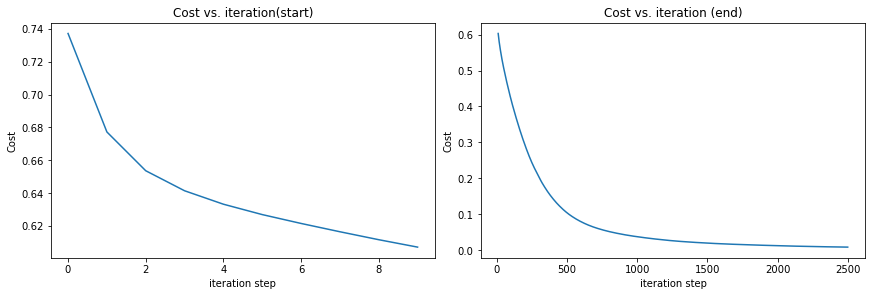

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))

ax1.plot(J_hist[:10])
ax2.plot(10 + np.arange(len(J_hist[10:])), J_hist[10:])
ax1.set_title("Cost vs. iteration(start)");  ax2.set_title("Cost vs. iteration (end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step')
plt.show()

# 4. Inference

In [14]:
with open('ckpts/ckpt_3B_NN_FC_multi_Layers.pkl', 'rb') as file_obj:
    params_ckpt = pickle.load(file_obj)

In [15]:
from sklearn.metrics import roc_curve, auc

def plot_ROC(y, y_pred):
    fpr, tpr, thresholds = roc_curve(y, y_pred)

    # auc
    print(f'auc score: {auc(fpr, tpr):.3f}')

    # plot
    plt.plot(fpr, tpr, linestyle='--', label='ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend(loc=4)
    plt.show()

def infer_dset(X, y, params, print_res=False):
    # Preprocess
    X_flatten = X.reshape(X.shape[0], -1)
    X_flatten = X_flatten/255.

    # (m, input_dim) -> (input_dim, m)
    X_flatten = X_flatten.T

    # Forward
    Z1 = nn_linear_forward(X_flatten, params['W1'], params['b1'])
    A1 = nn_activation_forward(Z1, activation='relu')

    Z2 = nn_linear_forward(A1, params['W2'], params['b2'])
    A2 = nn_activation_forward(Z2, activation='relu')

    Z3 = nn_linear_forward(A2, params['W3'], params['b3'])
    A3 = nn_activation_forward(Z3, activation='relu')

    Z4 = nn_linear_forward(A3, params['W4'], params['b4'])
    A4 = nn_activation_forward(Z4, activation='tanh')

    Z5 = nn_linear_forward(A4, params['W5'], params['b5'])
    Y_hat = nn_activation_forward(Z5, activation='sigmoid')
    y_hat = Y_hat.reshape(-1)

    # accuracy
    accuracy = np.mean((y_hat >= 0.5) == y)*100.0
    print(f"Accuracy = {accuracy:.2f}%")
    
    # AUC
    plot_ROC(y, y_hat)

train_x_orig.shape = (209, 64, 64, 3) train_y.shape = (209,)
Accuracy = 100.00%
auc score: 1.000


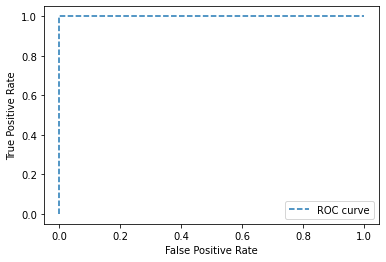

In [16]:
print(f'{train_x_orig.shape = }', f'{train_y.shape = }')
infer_dset(train_x_orig, train_y, params_ckpt)

test_x_orig.shape = (50, 64, 64, 3) test_y.shape = (50,)
Accuracy = 72.00%
auc score: 0.816


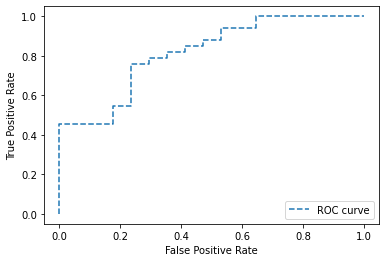

In [17]:
print(f'{test_x_orig.shape = }', f'{test_y.shape = }')
infer_dset(test_x_orig, test_y, params_ckpt)